## **Import** **Libraries**

In [0]:
# import tensorflow as tf #Tensorflow lib
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
import time 
from google.colab import files

In [2]:
!pip install tensorflow==1.4

# **Import Data**

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/MNIST/",one_hot=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /MNIST/t10k-labels-idx1-ubyte.gz


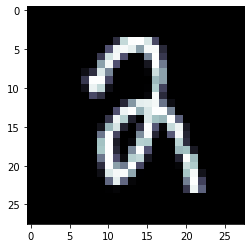

In [13]:
import tensorflow as tf
i = random.randint(0,mnist.train.images.shape[0])
plt.imshow(mnist.train.images[i].reshape(28,28), cmap="bone")

# **Generator Model**

In [0]:
def Generator(z,reuse=None):
  alpha = 0.01
  with tf.variable_scope("gen", reuse=reuse):
    h1 = tf.layers.dense(inputs=z, units=128)
    h1 = tf.maximum(alpha*h1, h1)
    h2 = tf.layers.dense(inputs = h1, units=128)
    h2 = tf.maximum(alpha*h2, h2)
    output = tf.layers.dense(h2, units=784, activation=tf.nn.tanh)
    return output

# **Discriminator Model**

In [0]:
def Discriminator(x, reuse=None):
  alpha = 0.01
  with tf.variable_scope("dis", reuse=reuse):
    h1 = tf.layers.dense(inputs=x, units=128)
    h1 = tf.maximum(alpha*h1, h1)
    h2 = tf.layers.dense(inputs = h1, units=128)
    h2 = tf.maximum(alpha*h2, h2)
    logits = tf.layers.dense(h2, units=1)
    output = tf.sigmoid(logits)
    return output, logits

# **Placeholders**

In [0]:
real_images = tf.placeholder(tf.float32, shape=[None,784])
z = tf.placeholder(tf.float32, shape=[None,100])

# Generator

In [0]:
G = Generator(z)

# **Discriminator**

In [0]:
D_output_real , D_logits_real = Discriminator(real_images)
D_output_fake, D_logits_fake = Discriminator(G,reuse=True)

# **Loss Function**

In [0]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [0]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9))
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))
D_loss = D_real_loss + D_fake_loss
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

# **Optimizer**

In [21]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [0]:
learning_rate = 0.01
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

# Training Section

In [0]:
batch_size = 100
epochs = 500
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)
# Save a sample per epoch
samples = []
count = 0

with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
            
        print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(Generator(z ,reuse=True),feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        if count % 20 == 0:
          plt.imshow(samples[0].reshape(28,28),cmap='bone')
        count+=1

        
#         saver.save(sess, './models/500_epoch_model.ckpt')

Currently on Epoch 1 of 500 total...
Currently on Epoch 2 of 500 total...
Currently on Epoch 3 of 500 total...
Currently on Epoch 4 of 500 total...
Currently on Epoch 5 of 500 total...
Currently on Epoch 6 of 500 total...
Currently on Epoch 7 of 500 total...
Currently on Epoch 8 of 500 total...
Currently on Epoch 9 of 500 total...
Currently on Epoch 10 of 500 total...
Currently on Epoch 11 of 500 total...
Currently on Epoch 12 of 500 total...
Currently on Epoch 13 of 500 total...
Currently on Epoch 14 of 500 total...
Currently on Epoch 15 of 500 total...
Currently on Epoch 16 of 500 total...
Currently on Epoch 17 of 500 total...
Currently on Epoch 18 of 500 total...
Currently on Epoch 19 of 500 total...
Currently on Epoch 20 of 500 total...
Currently on Epoch 21 of 500 total...
Currently on Epoch 22 of 500 total...
Currently on Epoch 23 of 500 total...
Currently on Epoch 24 of 500 total...
Currently on Epoch 25 of 500 total...
Currently on Epoch 26 of 500 total...
Currently on Epoch 27

In [0]:
plt.imshow(samples[0].reshape(28,28),cmap='bone')